In [16]:
import numpy as np
from sklearn.datasets import make_classification, load_iris, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
import torch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import openml
from simple_model import DyadOneHotPairDataset, DyadRankingModel, create_dyads, ConformalPredictor, ConformalRankingPredictor, MCDyadOneHotPairDataset

torch.set_default_device("cpu")
torch.get_default_device()

device(type='cpu')

In [17]:
dataset = openml.datasets.get_dataset(187)
X, y, _, _ = dataset.get_data(
    target=dataset.default_target_attribute, dataset_format="dataframe"
)

# Automatically identify categorical and numerical columns
categorical_features = X.select_dtypes(
    include=["object", "category"]
).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)

# Encode labels
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Preprocessing for numerical data: Impute missing values, then scale
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# Preprocessing for categorical data: Impute missing values, then one-hot encode
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train = preprocessor.fit_transform(X_train)


In [18]:
from simple_model import ClassifierModel, DyadRankingModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# clf = ClassifierModel(input_dim = X_train.shape[1], hidden_dim=16, output_dim=y.max()+1)
rf = RandomForestClassifier()

clf = ClassifierModel(input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes)

cp = ConformalPredictor(clf, alpha=0.05)

if not isinstance(X_train, np.ndarray):
    X_train = X_train.to_numpy()
if not isinstance(y_train, np.ndarray):
    y_train = y_train.to_numpy()
if not isinstance(X_test, np.ndarray):
    X_test = X_test.to_numpy()
if not isinstance(y_test, np.ndarray):
    y_test = y_test.to_numpy()

clf
cp.fit(X_train, y_train, num_epochs=1000, random_state=1, patience=64)
pred_sets_clf = cp.predict_set(X_test)

crp = ConformalRankingPredictor(num_classes=num_classes, alpha= 0.05)
crp.fit(X_train,y_train, random_state=1, use_cross_isntance_data=True, num_epochs=1000, patience=64)

pred_sets_rnk = crp.predict_set(X_test)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (36x13 and 12x16)

In [4]:
cp.model.gradient_updates

336

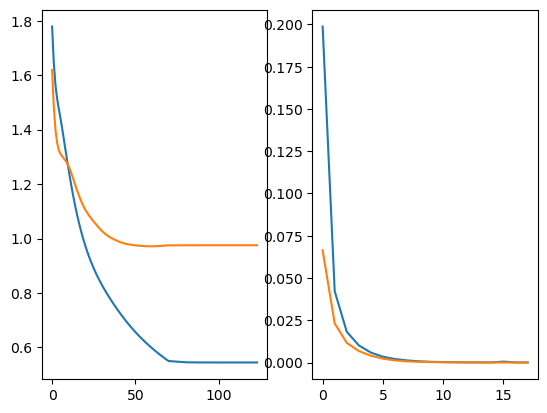

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)

axes = axes.ravel()

epochs_cp = np.arange(len(cp.model.train_losses))
epochs_crp = np.arange(len(crp.model.train_losses))

axes[0].plot(epochs_cp, cp.model.train_losses, label="train")
axes[0].plot(epochs_cp, cp.model.val_losses, label="val")
axes[1].plot(epochs_crp, crp.model.train_losses, label="train")
axes[1].plot(epochs_crp, crp.model.val_losses, label="val")

In [11]:

if not isinstance(X_test, np.ndarray):
    X_test = X_test.to_numpy()
if not isinstance(y_test, np.ndarray):
    y_test = y_test.to_numpy()



coverage_clf = np.mean([y_test[i] in pred_sets_clf[i] for i in range(len(y_test))])
efficiency_clf = np.mean([len(pred_sets_clf[i]) for i in range(len(y_test))])

coverage_rnk = np.mean([y_test[i] in pred_sets_rnk[i] for i in range(len(y_test))])
efficiency_rnk = np.mean([len(pred_sets_rnk[i]) for i in range(len(y_test))])
y_test_clf = cp.model.predict(X_test)
y_test_rnk = crp.model.predict(X_test)
# y_test_rf = rf.predict(X_test)

print(f"Accuracy clf {accuracy_score(y_test_clf, y_test)}")
# print(f"Accuracy rf {accuracy_score(y_test_rf, y_test)}")
print(f"Accuracy rnk {accuracy_score(y_test_rnk, y_test)}")

print(f"Coverage clf {coverage_clf} efficiency clf {efficiency_clf}")
print(f"Coverage rnk {coverage_rnk} efficiency rnk {efficiency_rnk}")


Accuracy clf 0.37209302325581395
Accuracy rnk 0.37209302325581395
Coverage clf 0.9767441860465116 efficiency clf 5.186046511627907
Coverage rnk 0.0 efficiency rnk 0.0


In [9]:
y_test

array([1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 3, 3, 2, 3, 0, 3, 1, 1, 0,
       2, 2, 1, 4, 1, 0, 5, 3, 1, 0, 1, 2, 5, 0, 4, 0, 1, 0, 0, 0, 1])

In [6]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.sum(X, axis=1).astype(int)

In [7]:
y

array([0, 1, 1, 2])

In [8]:
from simple_model import MCDyadOneHotPairDataset, DyadOneHotPairDataset
ds = DyadOneHotPairDataset(X, y, num_classes=3)


In [9]:
for x in ds:
    print(x)

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]])
tensor([[0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0.]])
tensor([[0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 1.]])
tensor([[1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0.]])
tensor([[1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.]])
tensor([[1., 1., 0., 0., 1.],
        [1., 1., 1., 0., 0.]])
tensor([[1., 1., 0., 0., 1.],
        [1., 1., 0., 1., 0.]])


In [10]:

ds_mc = MCDyadOneHotPairDataset(X, y, num_classes=3, num_pairs=-1)
for x in ds_mc:
    print(x)

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.]])
tensor([[0., 0., 1., 0., 0.],
        [1., 1., 0., 1., 0.]])
tensor([[1., 1., 0., 0., 1.],
        [1., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0.]])
tensor([[1., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1.]])
tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1.]])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])
tensor([[0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0.]])
tensor([[0., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0.]])
tensor([[1., 1., 0., 0., 1.],
        [0., 1., 1., 0., 0.]])
tensor([[1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.]])
tensor([[1., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1.]])
tensor([[1., 0., 0., 1., 0.],
        [1., 1., 0., 1., 0.]])
tensor([[0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0.]])
tensor([[1., 0., 0., 1., 0.],
        [1., 1., 1., 0., 0.]])
tensor([[0., 0., 1., 0.,

In [11]:
len(ds_mc)

31

In [12]:
from torch.utils.data import Dataset, DataLoader, random_split
from simple_model import TabularDataset
random_state = 1

X,y = make_classification(n_samples=1000, n_classes=5, n_informative=5)
dataset = TabularDataset(X, y)
gen = torch.Generator().manual_seed(random_state)
train_dataset, val_dataset = random_split(
    dataset, [1 - 1/3, 1/3], generator=gen
)
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [13]:
for input, labels in train_loader:
    print(len(labels))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
27


In [14]:
from torch.utils.data import Dataset, DataLoader, random_split
from simple_model import TabularDataset
from math import ceil, log2
random_state = 1
num_classes=5

X,y = make_classification(n_samples=1000, n_classes=num_classes, n_informative=5)
num_pairs = ceil(len(X_train) * log2(len(X_train)) * num_classes)
dataset = MCDyadOneHotPairDataset(X, y,num_classes=num_classes,num_pairs=num_pairs, random_state=random_state)
gen = torch.Generator().manual_seed(random_state)
train_dataset, val_dataset = random_split(
    dataset, [1 - 1/3, 1/3], generator=gen
)
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [22]:
a = 0
for x in train_loader:
    print(len(x))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
5
